# Playing around with neural networks and medical stock prices

Steps:

* Gather data on all the stocks (closing prices)
* Choose 3 stocks to predict
* Make X, T
* Find highly correlated stocks with output
* Test different neural networks on data
* Script the automation of daily prediction.
* Cite Sources

In [2]:
! python3 gatherData.py

WIKI/BKD
WIKI/CSU
WIKI/CYH
WIKI/FVE
WIKI/HCA
WIKI/KND
WIKI/LPNT
WIKI/NHC
WIKI/SEM


In [4]:
!head -10 medical_stock_prices.csv

Date,BKD,CSU,CYH,FVE,HCA,KND,LPNT,NHC,SEM
2000-12-12,,2.25,31.434594775619555,,,,40.25,2.622836614371434,
2000-12-13,,2.25,31.22635298057602,,,,40.13,2.803721898121188,
2000-12-14,,2.5,30.01656731413262,,,,40.56,3.5272630331202044,
2000-12-15,,2.5,30.442967180174143,,,,43.5,3.9794762424945898,
2000-12-18,,2.75,31.73208305425318,,,,46.25,4.88390266124336,
2000-12-19,,2.62,31.48417615539183,,,,46.5,5.155230586867991,
2000-12-20,,2.44,32.82287340924314,,,,46.75,5.200813678372929,
2000-12-21,,2.5,31.73208305425318,,,,44.44,5.064787944993114,
2000-12-22,,2.5,33.2195244474213,,,,45.75,4.88390266124336,


In [3]:
import csv
import pandas
import numpy as np
import matplotlib.pyplot as plt
import random
import neuralnetworks as nn

In [4]:
def csv_read(filename):
	with open(filename, 'r') as f:
		reader = csv.reader(f)
		matrix = list(reader)
	return matrix

In [5]:
data = pandas.read_csv("./medical_stock_prices.csv")
data = data.drop(['Date'], axis=1)
data.shape

(3533, 9)

#### Drop all rows with 'nan'

In [6]:
data = data.dropna()
data.shape

(959, 9)

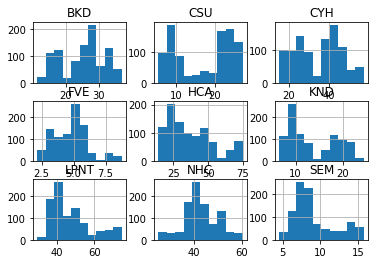

In [7]:
data.hist()
plt.show()

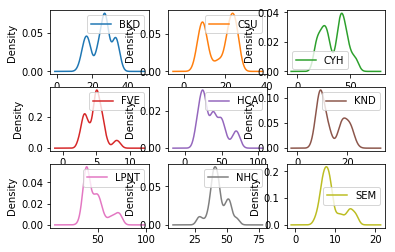

In [125]:
data.plot(kind='density', subplots=True, layout=(3,3), sharex=False)
plt.show()

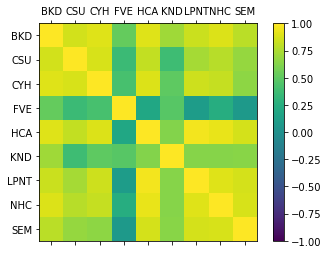

In [131]:
correlations = data.corr()
names = data[0:]
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

#### FVE and KND look to be the least correlated with other things actually...
#### Let's use BKD and NHC as our outputs.

In [132]:
T = data[['BKD', 'NHC']]
T = np.array(T)
X = data.drop(['BKD', 'NHC'], axis=1)
X = np.array(X)
(X.shape, T.shape)

((959, 7), (959, 2))

In [140]:
nRows = X.shape[0]
rows = np.arange(nRows)
np.random.shuffle(rows)
nTrain = int(nRows * 0.8)
trainRows = rows[:nTrain]
testRows = rows[nTrain:]
Xtrain, Ttrain = X[trainRows, :], T[trainRows, :]
Xtest, Ttest = X[testRows, :], T[testRows, :]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((767, 7), (767, 2), (192, 7), (192, 2))

In [15]:
def rmse(A, B):
    return np.sqrt(np.mean((A - B)**2))

hiddens = [0, [1], [1, 1], [1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1, 1], [5], [5, 5], [5, 5, 5], [5, 5, 5, 5], [5, 5, 5, 5, 5], [10], [10, 10], [10, 10, 10], [10, 10, 10, 10], [10, 10, 10, 10, 10], [20], [20, 20], [20, 20, 20], [20, 20, 20, 20], [20, 20, 20, 20, 20], [50], [50, 50], [50, 50, 50], [50, 50, 50, 50], [50, 50, 50, 50, 50]]
                       0         1         2
0                      0  1.717315  1.746972
1                    [1]  1.979314  2.030055
2                 [1, 1]  1.982144  2.028789
3              [1, 1, 1]  1.992448  2.038409
4           [1, 1, 1, 1]  1.996876  2.042493
5        [1, 1, 1, 1, 1]  2.003033  2.046857
6                    [5]  1.103471  1.099134
7                 [5, 5]  1.000902  1.051072
8              [5, 5, 5]  1.050339  1.089532
9           [5, 5, 5, 5]  1.017268  1.060050
10       [5, 5, 5, 5, 5]  1.134203  1.135194
11                  [10]  0.943429  0.963467
12              [10, 10]  0.738892  0.842609
13          [10, 10, 10]  0.807743  

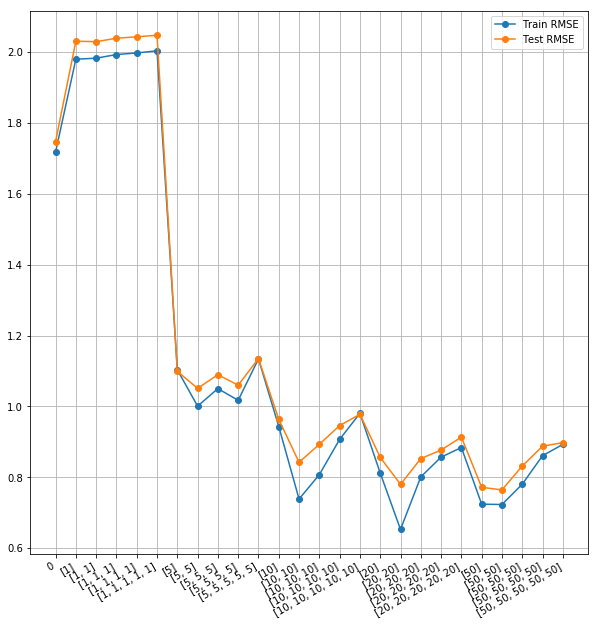

In [148]:
errors = []
hiddens = [0] + [[nu] * nl for nu in [1, 5, 10, 20, 50] for nl in [1, 2, 3, 4, 5]]
print('hiddens =', hiddens)
for hids in hiddens: 
    nnet = nn.NeuralNetwork(Xtrain.shape[1], hids, Ttrain.shape[1])
    nnet.train(Xtrain, Ttrain, 500)
    errors.append([hids, rmse(Ttrain, nnet.use(Xtrain)), rmse(Ttest, nnet.use(Xtest))])
errors = pandas.DataFrame(errors)
print(errors)

plt.figure(figsize=(10, 10))
plt.plot(errors.values[:, 1:], 'o-')
plt.legend(('Train RMSE', 'Test RMSE'))
plt.xticks(range(errors.shape[0]), hiddens, rotation=30, horizontalalignment='right')
plt.grid(True)
plt.show()

##### Basically, this means that the [20,20] configuration did great at prediction. Let's test iterations and see if that makes a difference:

hiddens = [20, 20]
nIterations = [10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
           0         1         2
0   [20, 20]  1.899394  1.877656
1   [20, 20]  1.653081  1.632451
2   [20, 20]  1.252646  1.215434
3   [20, 20]  1.101137  1.079588
4   [20, 20]  1.028645  1.046500
5   [20, 20]  0.919996  0.945384
6   [20, 20]  0.912181  0.946685
7   [20, 20]  0.862580  0.891571
8   [20, 20]  0.815071  0.831899
9   [20, 20]  0.773611  0.829267
10  [20, 20]  0.794964  0.820569
11  [20, 20]  0.698323  0.776787


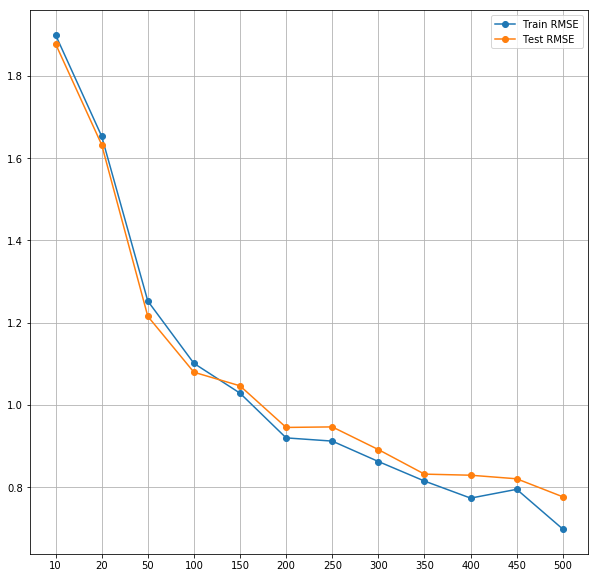

In [151]:
errors = []
hiddens = [20,20]
nIterationsList = [10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
print('hiddens =', hiddens)
print('nIterations =', nIterationsList)
for iters in nIterationsList: 
    nnet = nn.NeuralNetwork(Xtrain.shape[1], hiddens, Ttrain.shape[1])
    nnet.train(Xtrain, Ttrain, iters)
    errors.append([hiddens, rmse(Ttrain, nnet.use(Xtrain)), rmse(Ttest, nnet.use(Xtest))])
errors = pandas.DataFrame(errors)


print(errors)
plt.figure(figsize=(10, 10))
plt.plot(errors.values[:, 1:], 'o-')
plt.legend(('Train RMSE', 'Test RMSE'))
plt.xticks(range(errors.shape[0]), nIterationsList) # , rotation=30, horizontalalignment='right')
plt.grid(True)
plt.show()

##### Optimal Configuration SO far: [20,20] layers with 500 iterations

### Let's do something useful with this network. Let's try to predict values for our two outputs a week in advance.

#### Steps:
* Make X
* Shift T by one week
* * remove last 7 rows of X
* * remove first 7 rows of T
* Run neural network configuration

In [160]:
T = data[['BKD', 'NHC']]
T = np.array(T)
T = T[7:]
X = data.drop(['BKD', 'NHC'], axis=1)
X = np.array(X)
X_Current_Week = X[-7:]
X = X[:-7]
(X.shape, T.shape)

((952, 7), (952, 2))

In [159]:
hiddens = [20,20]
nIters = 500

nnet = nn.NeuralNetwork(X.shape[1], hiddens, T.shape[1])
nnet.train(X, T, nIters)
rmse(T, nnet.use(X))

0.88774731435267529

##### .8 is our root mean square error for predicting a week out.
#### Use the network 

In [34]:
X_Current_Week.shape

(7, 9)

In [163]:
nnet.use(X_Current_Week)

array([[ 35.39332633,  59.52123921],
       [ 35.23014995,  59.8670973 ],
       [ 35.08798761,  58.92872514],
       [ 35.05203567,  58.14828093],
       [ 35.12963817,  58.42374084],
       [ 35.25068431,  58.56998377],
       [ 35.17689705,  58.71564332]])

##### Essentially, Jan 6, 2015 stock prices for BKD and NHC should be 35.17 and 58.71


##### Jan 6: 
* BKD = 36.06
* NHC = 61.63

##### My data up to 12/30/2014 doesn't match yahoo though

#### NHC is in a dip from 12/31 to 1/9. Let's try predicting 3 weeks in advance and see if our algorithm can predict the correction.

In [170]:
T = data[['BKD', 'NHC']]
T = np.array(T)
T = T[21:]
X = data.drop(['BKD', 'NHC'], axis=1)
X = np.array(X)
X_Current_Week = X[-21:]
X = X[:-21]
(X.shape, T.shape)

((938, 7), (938, 2))

In [171]:
hiddens = [20,20]
nIters = 1000

nnet = nn.NeuralNetwork(X.shape[1], hiddens, T.shape[1])
nnet.train(X, T, nIters)
rmse(T, nnet.use(X))

0.77113384062221102

In [187]:
twentyOneDaysLater = nnet.use(X_Current_Week)
twentyOneDaysLater

array([[ 36.79952151,  60.47440177],
       [ 36.92388753,  60.23662891],
       [ 37.70720419,  61.12672142],
       [ 36.90275311,  59.12392264],
       [ 36.16940529,  57.48897989],
       [ 36.21998651,  57.48447062],
       [ 35.9960481 ,  56.98751342],
       [ 36.12172207,  57.13340958],
       [ 35.61359849,  56.37124949],
       [ 35.47984782,  56.32867021],
       [ 36.58255014,  58.32844814],
       [ 36.49164911,  58.16468979],
       [ 36.29457518,  57.58102067],
       [ 35.29932898,  55.76947648],
       [ 35.75150012,  56.10532246],
       [ 36.13708867,  57.02640041],
       [ 35.29621576,  55.41750601],
       [ 35.25117805,  55.20798716],
       [ 35.93993515,  56.50711106],
       [ 35.77326847,  56.05400612],
       [ 35.68240333,  55.92261246]])

##### 21 days out: meaning 1/21/2015 should be:
* BKD = 35.68
* NHC = 55.922

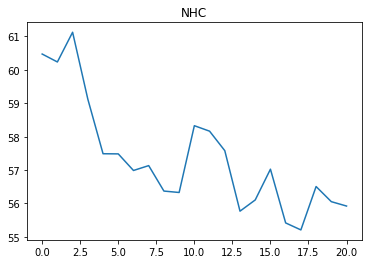

In [189]:
plt.plot(twentyOneDaysLater[:, 1])
plt.title("NHC")
plt.show()

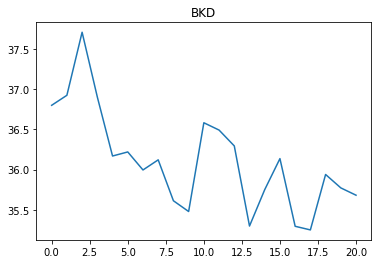

In [190]:
plt.plot(twentyOneDaysLater[:, 0])
plt.title("BKD")
plt.show()

#### It's predicting almost the exact same trends for BKD and NHC 
##### And they're both not very good predictions

# Ideas
* Get current and accurate data
* Compare stocks with themselves, using past week data to predict next week data
* * X = X[:-7]
* * T = X[7:]
* * That way each stock is predicting itself
* Do the same thing as above, except include BKD and NHC in X (Just a week behind, like the rest of X)

##### Let's compare stocks with their past week:

In [9]:
T = data[['BKD']]
T = T.transpose()
T = np.array(T)
T.shape

(1, 959)

In [10]:
X = []
for i in range(1, T.shape[1] - 28):
    X.append(T[0, i:i+21])
X = np.array(X)
X.shape

(930, 21)

In [11]:
T = np.array(np.transpose(T))
T = T[29:]
T.shape

(930, 1)

In [12]:
X[1]

array([ 27.23,  27.09,  26.12,  25.75,  25.9 ,  26.47,  26.17,  25.77,
        26.75,  26.89,  27.08,  27.67,  28.05,  28.  ,  27.98,  27.88,
        27.87,  27.52,  26.89,  26.5 ,  26.47])

##### Should be predicting 8 days in advance

In [13]:
nRows = X.shape[0]
rows = np.arange(nRows)
np.random.shuffle(rows)
nTrain = int(nRows * 0.8)
trainRows = rows[:nTrain]
testRows = rows[nTrain:]
Xtrain, Ttrain = X[trainRows, :], T[trainRows, :]
Xtest, Ttest = X[testRows, :], T[testRows, :]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((744, 21), (744, 1), (186, 21), (186, 1))

hiddens = [0, [1], [1, 1], [1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1, 1], [5], [5, 5], [5, 5, 5], [5, 5, 5, 5], [5, 5, 5, 5, 5], [10], [10, 10], [10, 10, 10], [10, 10, 10, 10], [10, 10, 10, 10, 10], [20], [20, 20], [20, 20, 20], [20, 20, 20, 20], [20, 20, 20, 20, 20], [50], [50, 50], [50, 50, 50], [50, 50, 50, 50], [50, 50, 50, 50, 50]]
                       0         1         2
0                      0  1.432018  1.443008
1                    [1]  1.416883  1.407497
2                 [1, 1]  1.417071  1.406572
3              [1, 1, 1]  1.417314  1.406321
4           [1, 1, 1, 1]  1.417178  1.407048
5        [1, 1, 1, 1, 1]  1.418861  1.405514
6                    [5]  1.367879  1.377549
7                 [5, 5]  1.318727  1.399213
8              [5, 5, 5]  1.321972  1.430789
9           [5, 5, 5, 5]  1.377996  1.415001
10       [5, 5, 5, 5, 5]  1.362066  1.486179
11                  [10]  1.315999  1.372499
12              [10, 10]  1.192083  1.394723
13          [10, 10, 10]  1.273015  

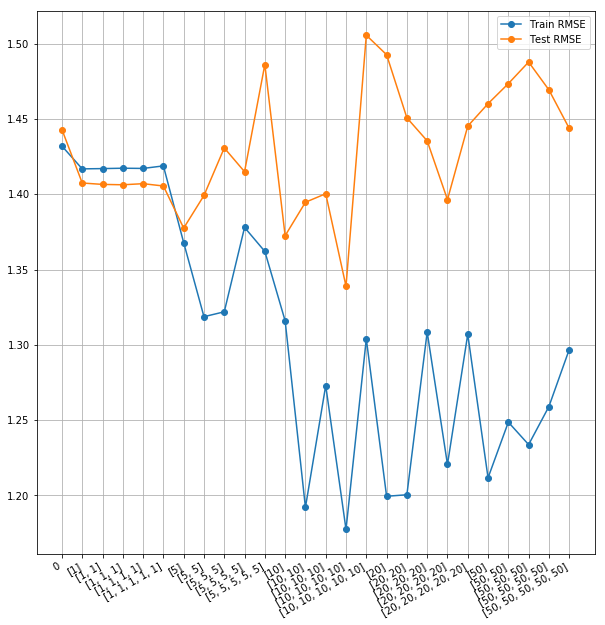

In [16]:
errors = []
hiddens = [0] + [[nu] * nl for nu in [1, 5, 10, 20, 50] for nl in [1, 2, 3, 4, 5]]
print('hiddens =', hiddens)
for hids in hiddens: 
    nnet = nn.NeuralNetwork(Xtrain.shape[1], hids, Ttrain.shape[1])
    nnet.train(Xtrain, Ttrain, 500)
    errors.append([hids, rmse(Ttrain, nnet.use(Xtrain)), rmse(Ttest, nnet.use(Xtest))])
errors = pandas.DataFrame(errors)
print(errors)

plt.figure(figsize=(10, 10))
plt.plot(errors.values[:, 1:], 'o-')
plt.legend(('Train RMSE', 'Test RMSE'))
plt.xticks(range(errors.shape[0]), hiddens, rotation=30, horizontalalignment='right')
plt.grid(True)
plt.show()

##### That's pretty frickin bad

Idea Implementation: Do the same thing as above, except include BKD and NHC in X (Just a week behind, like the rest of X)

In [24]:
T = data[['BKD', 'NHC']]
T = np.array(T)
T = T[7:]
X = data
X = np.array(X)
X_Current_Week = X[-7:]
X = X[:-7]
(X.shape, T.shape)

((952, 9), (952, 2))

In [22]:
nRows = X.shape[0]
rows = np.arange(nRows)
np.random.shuffle(rows)
nTrain = int(nRows * 0.8)
trainRows = rows[:nTrain]
testRows = rows[nTrain:]
Xtrain, Ttrain = X[trainRows, :], T[trainRows, :]
Xtest, Ttest = X[testRows, :], T[testRows, :]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((761, 9), (761, 2), (191, 9), (191, 2))

hiddens = [0, [1], [1, 1], [1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1, 1], [5], [5, 5], [5, 5, 5], [5, 5, 5, 5], [5, 5, 5, 5, 5], [10], [10, 10], [10, 10, 10], [10, 10, 10, 10], [10, 10, 10, 10, 10], [20], [20, 20], [20, 20, 20], [20, 20, 20, 20], [20, 20, 20, 20, 20], [50], [50, 50], [50, 50, 50], [50, 50, 50, 50], [50, 50, 50, 50, 50]]
                       0         1         2
0                      0  1.463815  1.513374
1                    [1]  1.950337  2.070318
2                 [1, 1]  1.951397  2.073681
3              [1, 1, 1]  1.986059  2.126162
4           [1, 1, 1, 1]  1.956143  2.082712
5        [1, 1, 1, 1, 1]  1.959243  2.087280
6                    [5]  1.163591  1.202625
7                 [5, 5]  1.114249  1.146227
8              [5, 5, 5]  1.095611  1.128019
9           [5, 5, 5, 5]  1.128758  1.140304
10       [5, 5, 5, 5, 5]  1.278286  1.286495
11                  [10]  0.993167  1.088518
12              [10, 10]  0.890291  1.016045
13          [10, 10, 10]  0.906625  

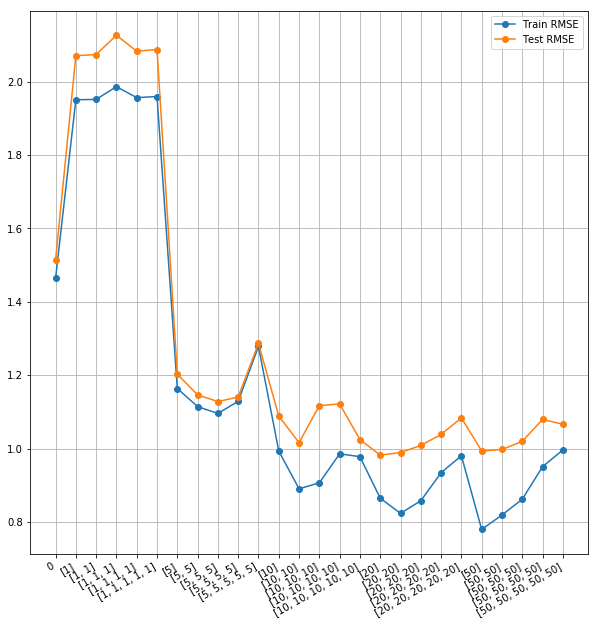

In [23]:
errors = []
hiddens = [0] + [[nu] * nl for nu in [1, 5, 10, 20, 50] for nl in [1, 2, 3, 4, 5]]
print('hiddens =', hiddens)
for hids in hiddens: 
    nnet = nn.NeuralNetwork(Xtrain.shape[1], hids, Ttrain.shape[1])
    nnet.train(Xtrain, Ttrain, 500)
    errors.append([hids, rmse(Ttrain, nnet.use(Xtrain)), rmse(Ttest, nnet.use(Xtest))])
errors = pandas.DataFrame(errors)
print(errors)

plt.figure(figsize=(10, 10))
plt.plot(errors.values[:, 1:], 'o-')
plt.legend(('Train RMSE', 'Test RMSE'))
plt.xticks(range(errors.shape[0]), hiddens, rotation=30, horizontalalignment='right')
plt.grid(True)
plt.show()

##### Not tooooooooo bad. Let's use [20,20] cause i like it better.

In [29]:
T = data[['BKD', 'NHC']]
T = np.array(T)
T = T[7:-7]
X = data
X = np.array(X)
X_Current_Week = X[-14:-7]
X = X[:-14]
(X.shape, T.shape)

((945, 9), (945, 2))

In [30]:
hiddens = [20,20]
nIters = 1000

nnet = nn.NeuralNetwork(X.shape[1], hiddens, T.shape[1])
nnet.train(X, T, nIters)
rmse(T, nnet.use(X))

0.60345009318591836

##### This line below "should" guess the last true 7 data points in the csv file for BKD and NHC

In [33]:
sevenDaysLater = nnet.use(X_Current_Week)
sevenDaysLater

array([[ 34.04464185,  58.26915402],
       [ 33.62124445,  57.5136905 ],
       [ 33.70800641,  57.0124366 ],
       [ 34.02349   ,  57.51813998],
       [ 34.44855886,  57.79352104],
       [ 34.91857471,  57.67371266],
       [ 34.59009498,  57.68883688]])

In [32]:
L = data[['BKD', 'NHC']]
L[-7:]

,BKD,NHC
3526,35.94,59.012733
3527,35.88,59.724633
3528,36.23,59.734000
3529,36.16,59.518557
3530,36.35,60.267925
3531,36.65,60.305393
3532,36.86,60.004055


##### So pretty much not the trends we want.... actually the exact opposite of what happened.